In [16]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [17]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 500
lr = 0.001
num_outputs = 10
seq_len = 100
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2114954


In [18]:
%matplotlib inline
trains = main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, seq_len, in_features, num_classes=num_outputs,cluster_type='make_blobs')

| epoch   0 | lr 0.0002 || validation loss 2.525
| epoch  10 | lr 0.0009996375239002368 || validation loss 2.103
| epoch  20 | lr 0.0009974242951402235 || validation loss 2.029
| epoch  30 | lr 0.000993208114306486 || validation loss 1.988
| epoch  40 | lr 0.0009870059584711668 || validation loss 1.751
| epoch  50 | lr 0.0009788428015268028 || validation loss 1.587
| epoch  60 | lr 0.0009687515136252732 || validation loss 1.566
| epoch  70 | lr 0.0009567727288213005 || validation loss 1.524
| epoch  80 | lr 0.0009429546814534529 || validation loss 1.482
| epoch  90 | lr 0.0009273530119214868 || validation loss 1.510
| epoch 100 | lr 0.0009100305426420956 || validation loss 1.440
| epoch 110 | lr 0.0008910570250852097 || validation loss 1.378
| epoch 120 | lr 0.0008705088589094458 || validation loss 1.458
| epoch 130 | lr 0.0008484687843276468 || validation loss 1.449
| epoch 140 | lr 0.0008250255489412463 || validation loss 1.362
| epoch 150 | lr 0.0008002735503850016 || validation los

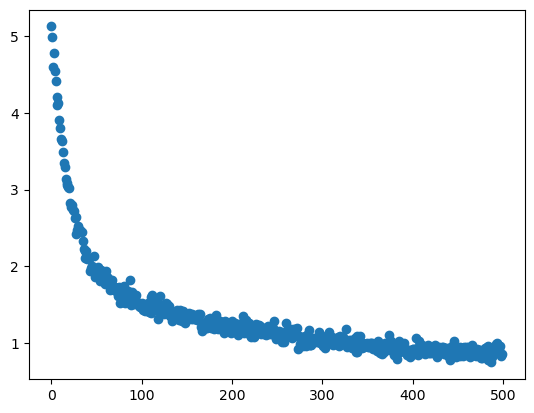

In [19]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

In [57]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5, cluster_type='dirichlet'
)
batch_classes = batch_classes.permute(1,0)
model.eval()
print("") 

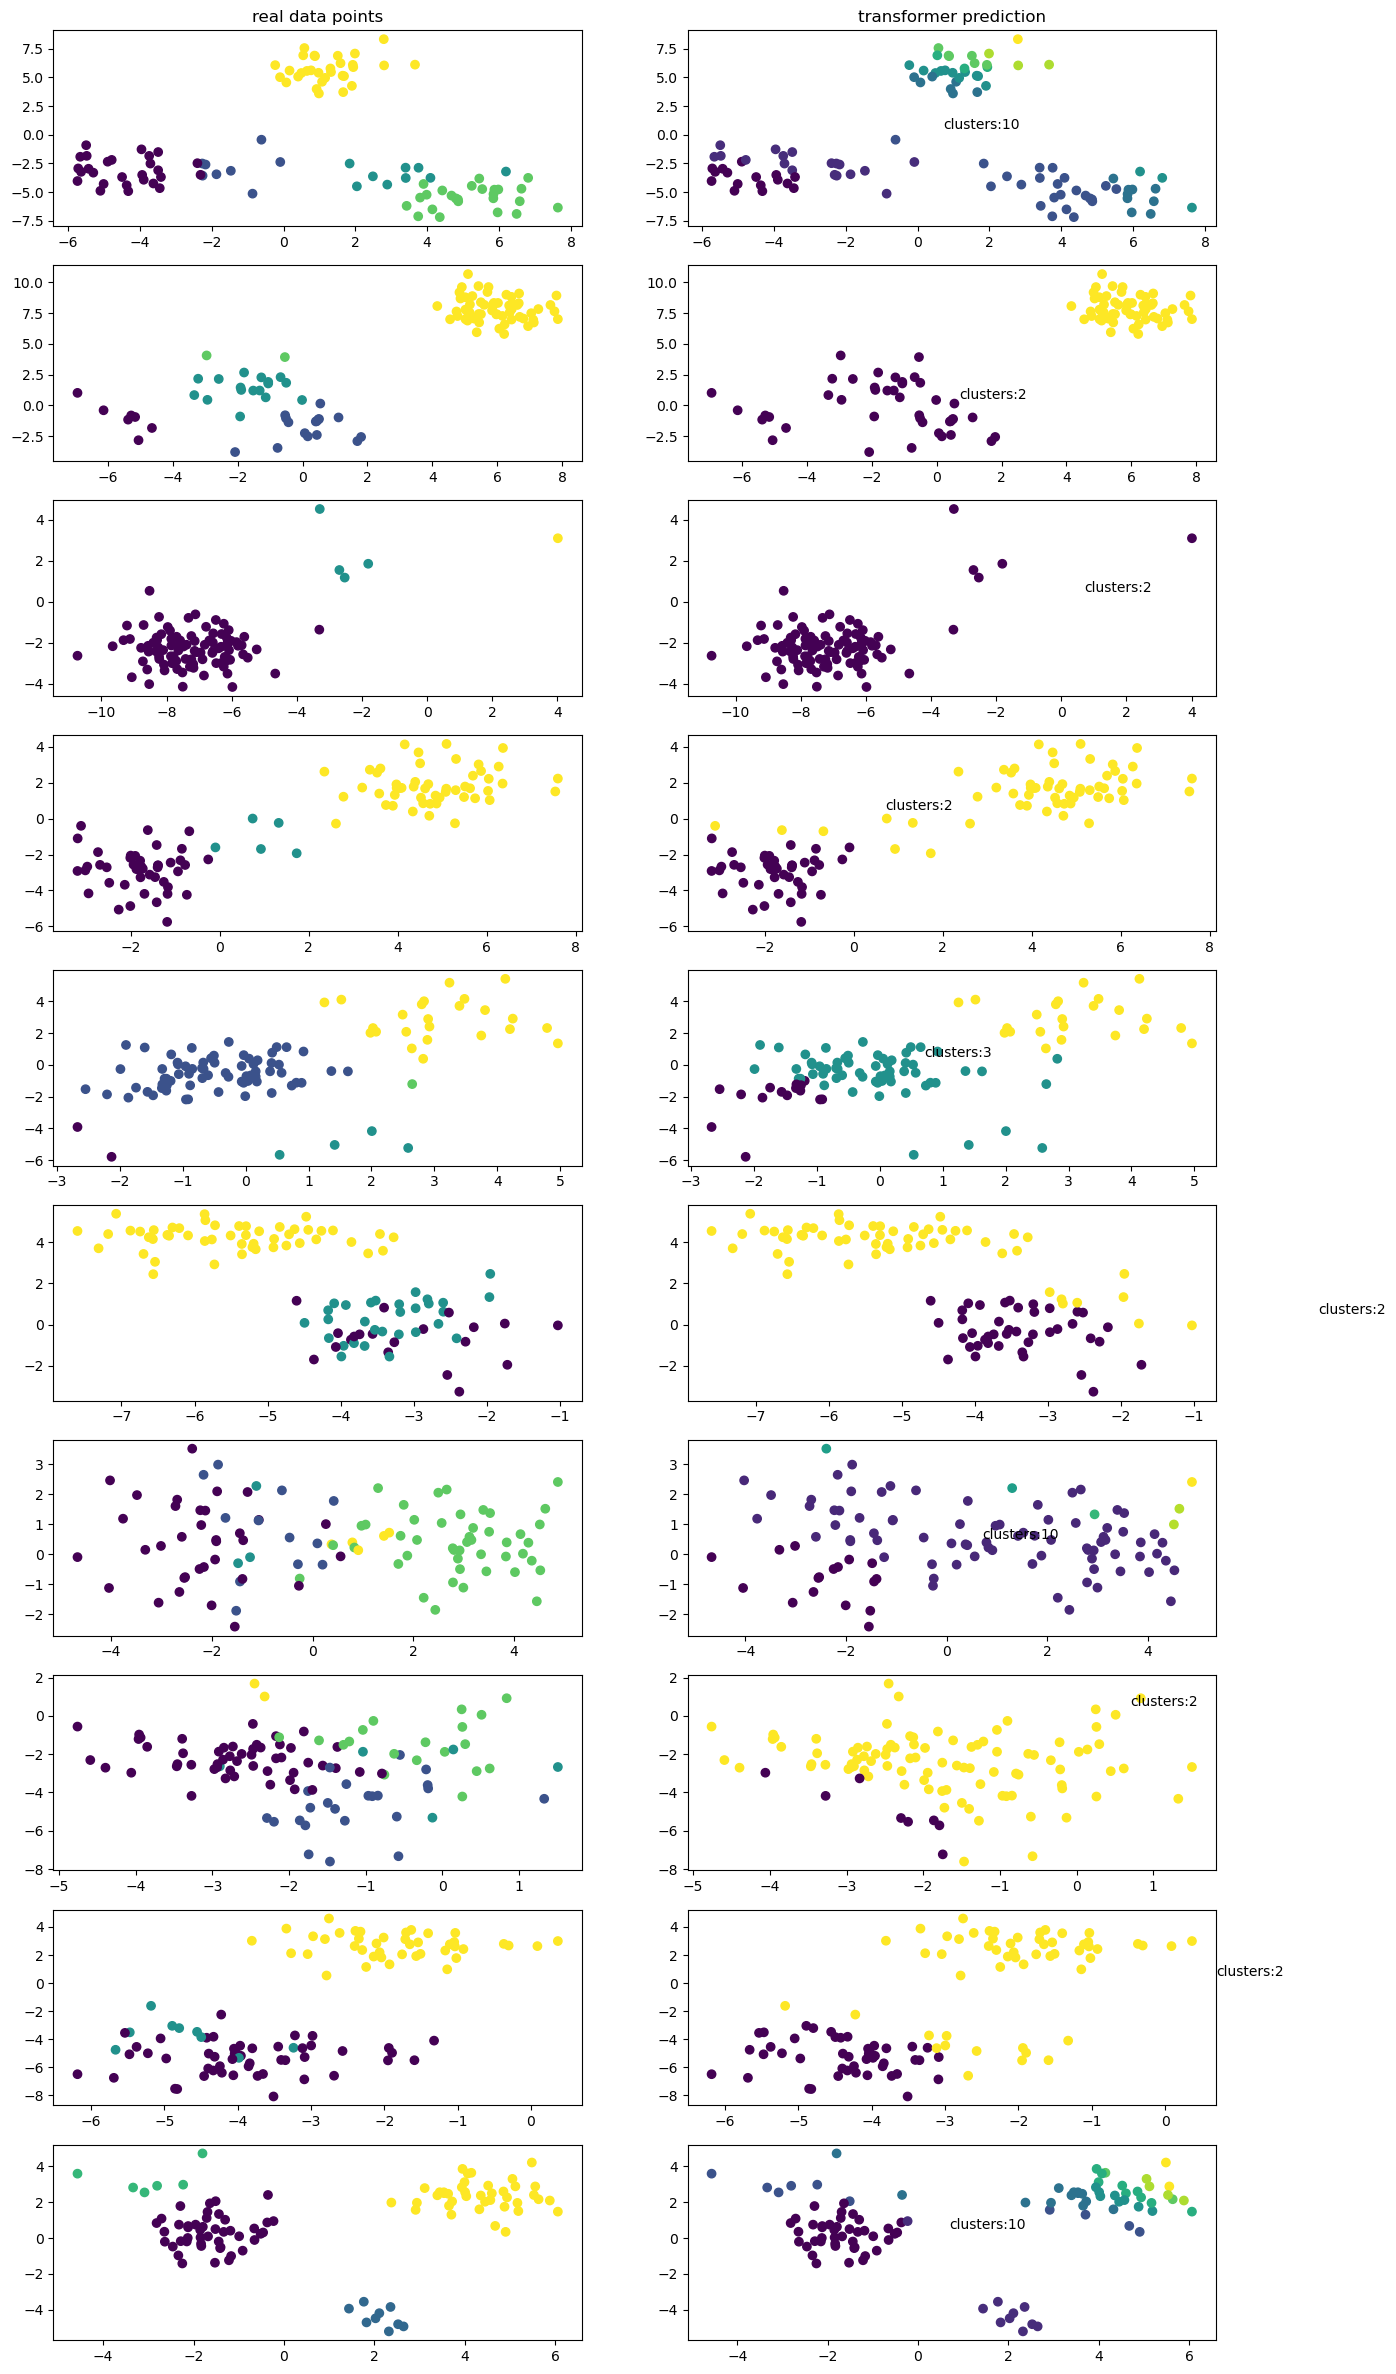

In [58]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x_true = X_true[:, batch_index].unsqueeze(1)
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    batch = batch_classes[batch_index].unsqueeze(-1)
    axes[2 * batch_index].scatter(train_x_true[:, 0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x, torch.full(batch.shape, 0, dtype=torch.long, device=device))
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x_true[:,0, 0].cpu().numpy() , train_x_true[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[2 * batch_index + 1].text(0.7, 0.5, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

In [33]:
temp_batch_size = 10
train_X, train_Y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5, cluster_type='make_blobs'
)

In [34]:
accuracy_buckets_pfn  =utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model,model_type='transformer')
accuracy_buckets_gmm = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model_type='gmm')
accuracy_buckets_kmeans = utils.compute_accuracy_distribution(X_true, train_Y, batch_classes,model,model_type='kmeans')

print(accuracy_buckets_pfn) 
print(accuracy_buckets_gmm) 
print(accuracy_buckets_kmeans) 

[0. 0. 1. 0. 4. 2. 2. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 8.]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 8.]


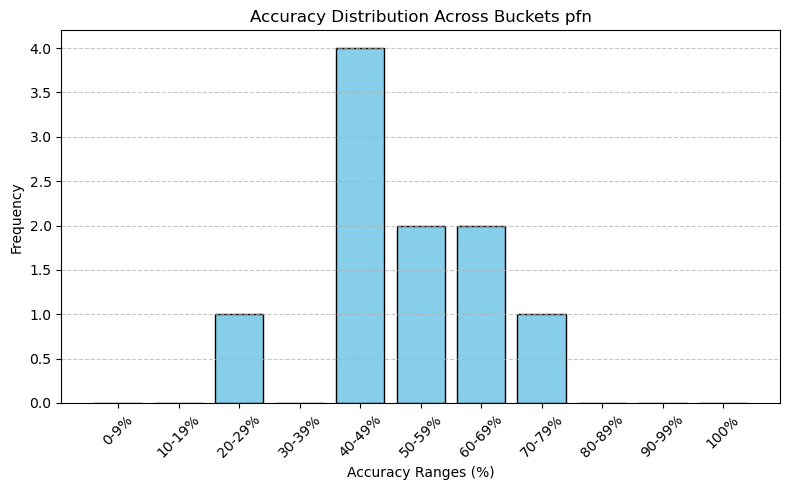

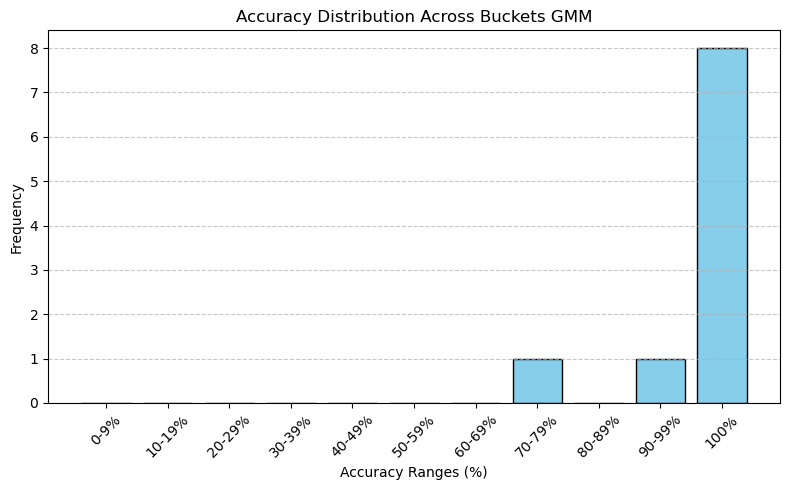

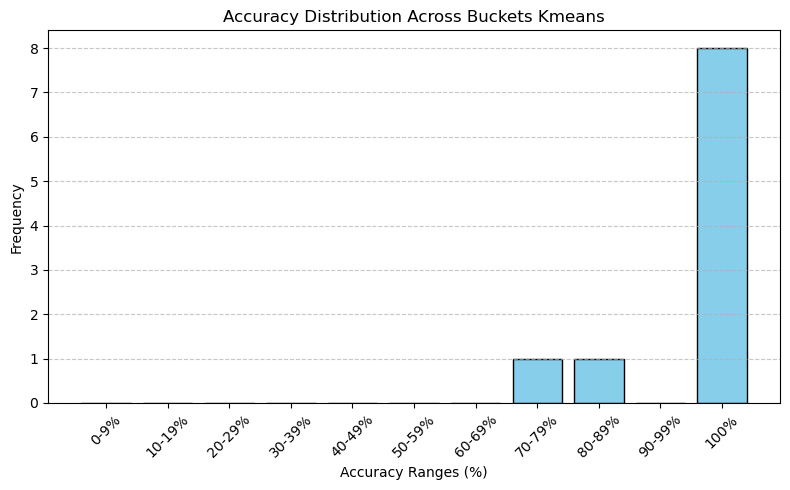

In [35]:
utils.plot_accuracy_metric(accuracy_buckets_pfn, 'pfn')
utils.plot_accuracy_metric(accuracy_buckets_gmm, 'GMM')
utils.plot_accuracy_metric(accuracy_buckets_kmeans, 'Kmeans')

In [63]:
temp_batch_size = 500
X, y, X_true, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=10, cluster_type='dirichlet'
)

In [64]:
unique_values, counts = torch.unique(batch_classes, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
Counts: tensor([  8,  34,  58, 113, 103,  80,  62,  28,   9,   5], device='cuda:0')
